In [1]:
import model as m 
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy
import math

In [2]:
age_class = ["<1", "1-4", "5-9", "10-14", "15-19", "20-29", "30+"]
#Select disease
d = "Mumps"

#monthly data
data = pd.read_csv( d +'_data_processed.csv')
monthly_data = data.iloc[:,1:8]
monthly_data = monthly_data[age_class]

#I do not consider 2019
monthly_data = monthly_data.iloc[0:(data.shape[0]),:]

time_date = data["Time"][0:(data.shape[0])]

if d== "Mumps":
    years_run = int(time_date[len(time_date)-1]) - int(time_date[0]) +1
    start_yr = int(time_date[0])
    end_yr = int(time_date[len(time_date)-1])
     
else:
    start_yr = int(time_date[0][0:4])
    end_yr = int(time_date[len(time_date)-1][0:4])
    years_run = int(time_date[len(time_date)-1][0:4]) - int(time_date[0][0:4]) +1

print(start_yr)
print(end_yr)
print(years_run, "--> tmax")

2000
2018
19 --> tmax


### Extracting birth and death rates for age groups:

* Death rates: *death_rate_7_age_groups_1982-2018.csv*: 
$$ d_i = \frac{\text{number of death people who are in i-th age group}}{\text{population in i-th age group}}$$
* Births: *Crude_birth_rate_1938-2018.csv*, unit is birth number per 1000 population
* Population: *population_7_age_groups_1982-2018.csv*

In [3]:
##### Births
Births = pd.read_csv("Data//Crude_birth_rate_1938-2018.csv")

#Select from year 1999 to 2018
if d == "Mumps":
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]
else:
    Births_years = Births.iloc[0:(end_yr-start_yr+1),:]

#Selecting 3rd column for UK data
Births_years_UK = Births_years.iloc[:,2] 

Births_UK =  Births_years_UK.to_numpy()
#We shall reverse the order to go from 1999 to 2018

Births_UK = np.asarray(list(reversed(Births_UK)))/1000 # Normalise to per capita
#### Deaths
Deaths = pd.read_csv("Data//death_rate_7_age_groups_1982-2018.csv")

#exclude last row (no total)
Deaths = Deaths.iloc[0:7,:]

#Selecting columns for years 1999-2018

Deaths_years = Deaths.iloc[:,np.where(Deaths.columns== str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#### Population
Pops = pd.read_csv("Data//population_7_age_groups_1982-2018.csv")

#Just need last row

Pops_tot = Pops.iloc[7,np.where(Deaths.columns==str(start_yr))[0][0]:np.where(Deaths.columns==str(end_yr))[0][0]+1]

#print(Pops_tot)

Pops_tot = np.asarray(Pops_tot)

##### Including real contact matrix from Polymod

- equally weighted one

In [10]:
Poly_7_new = pd.read_csv("Data/Poly_7.csv")
Poly_7_new = Poly_7_new.iloc[:,1:8]
Poly_7_new = Poly_7_new.iloc[np.hstack([6, np.arange(0,6)]),:]

C_poly = Poly_7_new.values

In [11]:
C_poly

array([[1.49      , 1.49      , 0.59      , 0.25      , 0.18      ,
        0.515     , 0.30111111],
       [1.49      , 1.49      , 0.59      , 0.25      , 0.18      ,
        0.515     , 0.30111111],
       [0.74      , 0.74      , 3.82      , 0.53      , 0.44      ,
        0.395     , 0.40222222],
       [0.36      , 0.36      , 0.73      , 3.19      , 0.79      ,
        0.155     , 0.30888889],
       [0.26      , 0.26      , 0.22      , 0.52      , 3.1       ,
        0.485     , 0.28555556],
       [0.92      , 0.92      , 0.56      , 0.2       , 0.58      ,
        1.515     , 0.41777778],
       [2.94      , 2.94      , 2.84      , 2.21      , 1.86      ,
        1.975     , 2.12777778]])

#### Vaccine coverage and Vaccinated IC

In [5]:
Cov_rate = pd.read_csv("Data//" +d +'_vaccine_coverage.csv')
V_ic = Cov_rate.iloc[0:7,1:2]
V_ic = V_ic.to_numpy().reshape((7,))/100
Cov_rate_years = Cov_rate.iloc[0:7,2:21]

# Issue: vaccination rate is up until 2016, now assume 2017-19 are the same?
Cov_rate_years["2017"] = Cov_rate_years["2018"]  = Cov_rate_years["2016"]

Cov_rate_years = Cov_rate_years.iloc[:,np.where(Cov_rate_years.columns== str(start_yr))[0][0]:np.where(Cov_rate_years.columns==str(end_yr))[0][0]+1]
Shift_cov_rate_years = Cov_rate_years.iloc[np.hstack([6, np.arange(0,6)]),:]

In [6]:
import multiprocessing

def get_yearly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, n_years, dtype=np.int32)])

def get_monthly_rates(Y_N, eval_per_year, n_years):
        return np.diff(Y_N[:,np.linspace(0, (eval_per_year-1)*n_years, 12*n_years, dtype=np.int32)])
                       
def f_ssq(beta_vec):
    n_eval=120
    beta = np.eye(7)*np.maximum(beta_vec,0.0025)
    mdl = m.SIRVModel(para, lambda t: beta)
    
    ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)    
    
    if d == "Mumps":
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, atol =1e-4, rtol = 1e-3)
        new_inf = get_yearly_rates(out_YN, n_eval, years_run)
    else:
        out, t, out_YN = mdl.run(ic ,t_max = years_run-0.0001,method="RK45", eval_per_year=n_eval, atol =1e-4, rtol = 1e-3)
        new_inf = get_monthly_rates(out_YN, n_eval, years_run)
    
    ssq = np.sum(np.sum((new_inf-np.reshape(monthly_data[age_class].to_numpy()[0:-1], (7,-1))*1e-5*pop_scale)**2))
    return ssq

def f_ssq_wrapper(beta_vec, ret):
    ret[0] = f_ssq(beta_vec)

def f_ssq_timeout(beta_vec):
    val = np.array([0])
    p = multiprocessing.Process(target=f_ssq_wrapper, args = (beta_vec,val))
    p.start()
    p.join(10)
    if p.is_alive():
        print("Maximum computation time exceeded")
        p.terminate()
        p.join()
        return 1e100
    else:
        return val[0]

Each age group IC is weighted by their percetange at first year pop

In [7]:
def estimate_SIR_IC(mdl, age_struct, pop_scale, V_ic, eps_I = 1e-6, k=7):
    ###Start with a population where anyone who isnt vaccinated is susceptible 
    #(+eps_I level of infections))
    S_ic = (np.ones(k)-V_ic)*(1-eps_I)
    I_ic = (np.ones(k)-V_ic-S_ic)*[1,1,1,1,1,1,1]
    R_ic = (np.ones(k) - S_ic - I_ic - V_ic)
    
    #Normalise profile
    norm_ic = np.hstack([S_ic*age_struct_start,  
                    I_ic*age_struct_start,
                    R_ic*age_struct_start,
                    V_ic*age_struct_start])*pop_scale
    
    ### Run for a year
    out, t, out_YN = mdl.run(norm_ic, 
                             t_max = 1.0,
                             method="RK45",
                             eval_per_year=120,
                             pop_scale=pop_scale, atol=1e-3, rtol=1e-4)
    
    ### Note this only works for sensible betas and gammas 
    ###(i.e. assumes epidemic over in a year)
    level_estimate = out[:, -1]
    
    S_level = level_estimate[0:k]
    I_level = level_estimate[k:2*k]
    R_level = level_estimate[2*k:3*k]
    
    S_const = S_level/(S_level+I_level+R_level)
    I_const = I_level/(I_level+R_level)
    
    S_ic_est = (np.ones(k)-V_ic)*S_const
    I_ic_est = (np.ones(k)-V_ic-S_ic_est)*I_const
    R_ic_est = (np.ones(k)-V_ic-S_ic_est-I_ic_est)
    
    estimated_IC = np.hstack([S_ic_est*age_struct_start,
                              I_ic_est*age_struct_start,
                              R_ic_est*age_struct_start,
                              V_ic*age_struct_start])*1000
        
    return(estimated_IC)    

In [8]:
#Prepare Model Parameters
pop_scale = 1000 #Set scale to cases per 1000 
age_struct_start = np.asarray(Pops[str(start_yr)][0:7]/np.sum(Pops[str(start_yr)][0:7]))

para = m.ModelParams(
    age_strucure=[0,1, 5, 10, 15, 20, 30],  #age cuts
    B= lambda t: (Births_UK*pop_scale)[int(np.floor(t))],  #births rate per 1000
    V=lambda t: (Shift_cov_rate_years.to_numpy()/100.0)[:, (int(np.floor(t))-1)],
    d=lambda t: Deaths_years.to_numpy()[:, int(np.floor(t))],  #death rate per capita
    gamma=(1/7*365.0)*np.ones([7]),
    C=C_poly*365,
    N= lambda t: Pops_tot[int(np.floor(t))]
)


### Setting correct recovery rate

* Measles: recovery period of 7 - 10 days
* Mumps: 1 to 2 weeks
* Rubella: 3 days 

In [47]:
if d == "Measles":
    para.gamma = (1/8.5 *365.0)*np.ones([7]) #I compute the average
elif d == "Mumps":
    para.gamma = (1/10 *365.0)*np.ones([7])
elif d == "Rubella":
    para.gamma = (1/3 *365.0)*np.ones([7])

[1.09807333e-03 6.19088667e-04 6.01176667e-02 5.41786667e-01
 3.06766667e+00 6.48682667e+00 1.73380000e-01]


Text(0.5, 1.0, 'Yearly infections per 100K - Mumps')

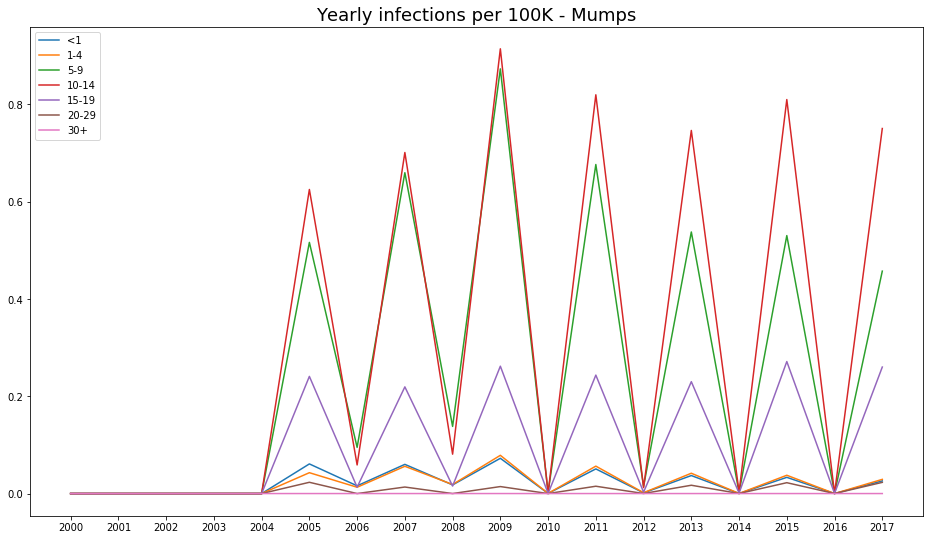

In [258]:
beta =   1.2* np.eye(7)*[0.00019,0.000073,0.0085,0.088, 0.5,0.32,0.03]  # best guess

#beta =   1.23* np.eye(7)*[0.0003,0.01,0.03,0.06, 0.1,0.05,0.02]  # best


print((beta@para.C/365)@np.ones(7))


mdl = m.SIRVModel(para, lambda t: beta)
ic = estimate_SIR_IC(mdl, age_struct_start, pop_scale, V_ic)

eval_year = 120
out, t, out_YN = mdl.run(ic ,t_max = years_run-0.00001, method="RK45", eval_per_year=eval_year, pop_scale=pop_scale, 
                         atol=1e-6, rtol = 1e-4)
"""""
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(t[0:len(t)], np.transpose(out[7+ii,0:len(t)]), label = age_class[ii])
plt.legend()
plt.title("Infected curve for all age groups (unnormalized)", fontsize = 18)
"""

plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.arange(0,years_run-1), 
             (1e5/pop_scale)*np.transpose(get_yearly_rates(out_YN, eval_year, years_run)[ii,:]), label = age_class[ii])

if d != "Mumps":
    locs, labels = plt.xticks()
    locs_mine = np.hstack([locs[1:-2], 19.5])
    plt.xticks(locs_mine, time_date[locs_mine*12])
else:
    plt.xticks(np.arange(0,years_run-1), time_date)

plt.legend()
plt.title("Yearly infections per 100K - Mumps", fontsize = 18)


Text(0.5, 1.0, 'Monthly infections per 100K')

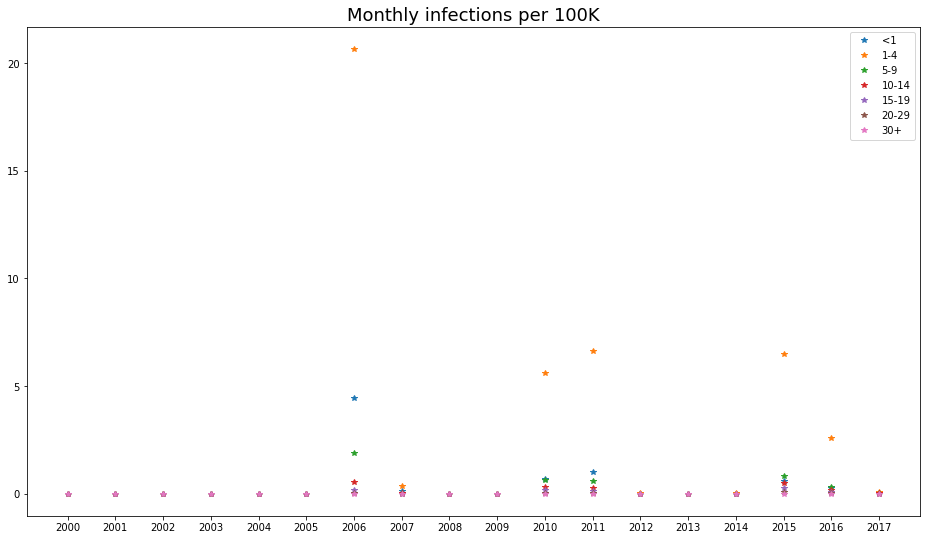

In [102]:
plt.figure(figsize=(16,9))
for ii in range(7):
    plt.plot(np.arange(0,years_run-1), 
             (1e5/pop_scale)*np.transpose(get_yearly_rates(out_YN, eval_year, years_run)[ii,:]), '*', label = age_class[ii])


plt.xticks(np.arange(0,years_run-1), time_date)
    
plt.legend()
plt.title("Monthly infections per 100K", fontsize = 18)


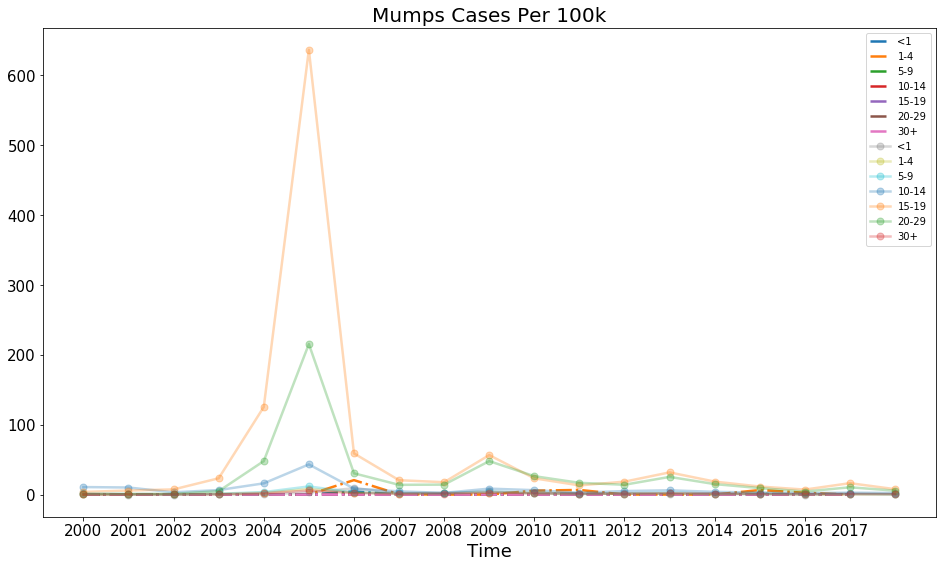

In [103]:
for d in ['Mumps']:
#for d in ['Measles']:
    #option for dotted in Mumps
    plt.figure(figsize=(16,9))
    for ii in range(7):
        plt.plot(np.arange(0,years_run-1), 
                 (1e5/pop_scale)*np.transpose(get_yearly_rates(out_YN, eval_year, years_run)[ii,:]),
                 lw = 2.5, linestyle ='-.', label = age_class[ii])   
    plt.yticks(fontsize = 15)
    
    plt.xlabel("Time", fontsize=18)
    plt.legend(shadow= True, fontsize = 19)
    plt.title(d+" Cases Per 100k", fontsize = 20)
    #svg better for Poster
    
    #plt.savefig(d+"Plot.svg")
    
    if d == "Mumps":
        for cc in age_class:
            plt.plot(np.arange(0,years_run),
                     monthly_data[cc], "-o", markersize = 7, lw = 2.5, label= cc, alpha = 0.3)
            plt.xticks(np.arange(0,years_run-1), time_date)
            plt.xticks(fontsize = 15)
            plt.yticks(fontsize = 15)
            
    plt.legend()
    #plt.title("Monthly infections per 100K", fontsize = 18)


## Plotting the scaled infected by normalising pop

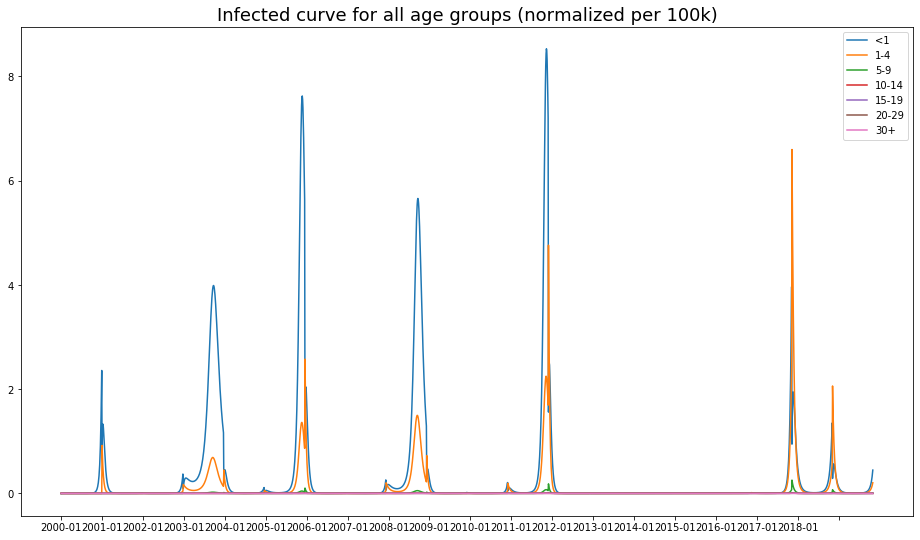

In [13]:
Inf_OUT = out[7:(7*2),:]
plt.figure(figsize=(16,9))
for ii in range(7):
    tot = np.sum(out[np.array([0,7,14,21])+ii,], axis=0)
    plt.plot(t[0:len(t)], (np.transpose(out[7+ii,]) / tot)[0:len(t)]*100, label = age_class[ii])
plt.legend()
if d == "Mumps":
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date)
else:
    plt.xticks(t[0:len(t)][np.arange(years_run)*eval_year], time_date[np.arange(1, years_run)*12])

plt.title("Infected curve for all age groups (normalized per 100k)", fontsize = 18)

if d == "Mumps":
    plt.savefig("Inf_sim_"+d+"_noOpt.svg")